In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [47]:
def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    val_dir = os.path.join(data_dir, "Validation")

    train_data = ImageFolder(root=train_dir, transform=transform)
    test_data = ImageFolder(root=test_dir, transform=transform)
    val_data = ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [48]:
data_dir = "Dataset"
train_loader, test_loader, val_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(train_loader.dataset.classes)
print(device)

cuda:0


In [49]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
print(f"Número de amostras de validação: {len(val_loader.dataset)}")
print("Classes no conjunto de treinamento:")
print(train_loader.dataset.classes)

Número de amostras de treinamento: 459
Número de amostras de teste: 50
Número de amostras de validação: 55
Classes no conjunto de treinamento:
['adidas', 'nike']


In [50]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, num_classes)
resnet = resnet.to(device)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

In [52]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

In [53]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss +=loss
    return val_loss/len(loader)

In [54]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [55]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

In [56]:
def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)
            loss += l1_reg
            l2_reg = l2_regularization(model, l2_lambda, device)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch+1} | Loss: {running_loss/len(trainloader)} | Val Loss: {val_loss}')

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
epochs = 30

In [58]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=0.00001, l2_lambda=0.00001)

 79%|███████▉  | 31/39 [00:18<00:04,  1.80it/s]c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 39/39 [00:22<00:00,  1.75it/s]


Epoch: 1 | Loss: 3.1510829558739295 | Val Loss: 0.08567333966493607


100%|██████████| 39/39 [00:14<00:00,  2.69it/s]


Epoch: 2 | Loss: 2.932291183716212 | Val Loss: 0.13425447046756744


100%|██████████| 39/39 [00:16<00:00,  2.42it/s]


Epoch: 3 | Loss: 2.8174183857746615 | Val Loss: 0.14883512258529663


100%|██████████| 39/39 [00:14<00:00,  2.63it/s]


Epoch: 4 | Loss: 2.7555423210828733 | Val Loss: 0.485662043094635


100%|██████████| 39/39 [00:15<00:00,  2.56it/s]


Epoch: 5 | Loss: 2.7221540059798803 | Val Loss: 0.40298667550086975


100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


Epoch: 6 | Loss: 2.8051583889203195 | Val Loss: 0.22569182515144348


100%|██████████| 39/39 [00:27<00:00,  1.39it/s]


Epoch: 7 | Loss: 2.7177796975160255 | Val Loss: 0.02090582810342312


100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


Epoch: 8 | Loss: 2.790804514518151 | Val Loss: 0.5507915019989014


100%|██████████| 39/39 [00:13<00:00,  2.85it/s]


Epoch: 9 | Loss: 2.7524905449304824 | Val Loss: 0.05725058540701866


100%|██████████| 39/39 [00:14<00:00,  2.73it/s]


Epoch: 10 | Loss: 2.6659822647388163 | Val Loss: 0.3106817901134491


100%|██████████| 39/39 [00:16<00:00,  2.43it/s]


Epoch: 11 | Loss: 2.661955069272946 | Val Loss: 0.1349450796842575


100%|██████████| 39/39 [00:17<00:00,  2.29it/s]


Epoch: 12 | Loss: 2.6214822928110757 | Val Loss: 0.21986912190914154


100%|██████████| 39/39 [00:16<00:00,  2.41it/s]


Epoch: 13 | Loss: 2.5771833138588147 | Val Loss: 0.7406343817710876


100%|██████████| 39/39 [00:15<00:00,  2.53it/s]


Epoch: 14 | Loss: 2.5584816810412283 | Val Loss: 0.41968464851379395


100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


Epoch: 15 | Loss: 2.5391462460542336 | Val Loss: 0.1289573460817337


100%|██████████| 39/39 [00:14<00:00,  2.72it/s]


Epoch: 16 | Loss: 2.5449877274342074 | Val Loss: 0.40279123187065125


100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


Epoch: 17 | Loss: 2.503139324677296 | Val Loss: 0.254421204328537


100%|██████████| 39/39 [00:16<00:00,  2.37it/s]


Epoch: 18 | Loss: 2.4940154185661902 | Val Loss: 0.13167324662208557


100%|██████████| 39/39 [00:13<00:00,  2.85it/s]


Epoch: 19 | Loss: 2.4889445243737636 | Val Loss: 0.25245124101638794


100%|██████████| 39/39 [00:13<00:00,  2.80it/s]


Epoch: 20 | Loss: 2.4510411665989804 | Val Loss: 0.16107694804668427


100%|██████████| 39/39 [00:14<00:00,  2.75it/s]


Epoch: 21 | Loss: 2.4381171128688712 | Val Loss: 0.04199257493019104


100%|██████████| 39/39 [00:13<00:00,  2.81it/s]


Epoch: 22 | Loss: 2.4844925036797156 | Val Loss: 0.159463033080101


100%|██████████| 39/39 [00:13<00:00,  2.86it/s]


Epoch: 23 | Loss: 2.5028596352308226 | Val Loss: 0.21610255539417267


100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Epoch: 24 | Loss: 2.4532818488585644 | Val Loss: 0.5041308999061584


100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Epoch: 25 | Loss: 2.4255016277997923 | Val Loss: 0.3844030797481537


100%|██████████| 39/39 [00:14<00:00,  2.73it/s]


Epoch: 26 | Loss: 2.340096498147035 | Val Loss: 0.16097059845924377


100%|██████████| 39/39 [00:13<00:00,  2.84it/s]


Epoch: 27 | Loss: 2.3218188346960607 | Val Loss: 0.41262778639793396


100%|██████████| 39/39 [00:14<00:00,  2.75it/s]


Epoch: 28 | Loss: 2.317453023714897 | Val Loss: 1.0167756080627441


100%|██████████| 39/39 [00:14<00:00,  2.78it/s]


Epoch: 29 | Loss: 2.4073475568722458 | Val Loss: 0.5312207341194153


100%|██████████| 39/39 [00:14<00:00,  2.65it/s]


Epoch: 30 | Loss: 2.3094274202982583 | Val Loss: 0.24378405511379242


A rede atinge: 94% de acurácia


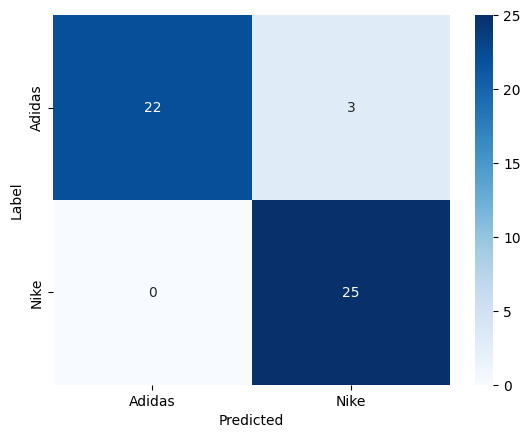

In [59]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
conf_mat = confusion_matrix(resnet, test_loader)

In [60]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

In [61]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

In [62]:
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')